In [15]:
'''
This notebook plots read length and depth distributions for MEL LRS data
Figure 1
'''

'\nThis notebook plots read length and depth distributions\n'

In [1]:
import os
import glob

import pysam
import pybedtools
from pybedtools import BedTool

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

from plotnine import *
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # export pdfs with editable font types in Illustrator

In [2]:
active_TSS = pd.read_csv('../annotation_files/active_TSS_PROseq_150_counts_mm10_VM20.txt', header = 0, sep = '\t')
active_transcripts = pd.read_csv('../annotation_files/active_transcripts.bed', sep = '\t', names = 
                                ['chr', 'start', 'end', 'txid', 'score', 'strand']) # BED 12 files from UCSC with coordinates based on active TSS list above

In [3]:
# Create a bed file of collapsed active genes: using TSS counts from PRO-seq to get active transcripts, then combine by gene ID and take largest stand and end coordinates possible
m = pd.merge(active_transcripts, active_TSS[['txname', 'geneid']], left_on = 'txid', right_on = 'txname', how = 'left')
g = m.groupby('geneid').agg({
    'chr':'first',
    'start':'min',
    'end':'max',
    'geneid':'first',
    'score':'first',
    'strand':'first'
})
g = g.sort_values(by = ['chr', 'start', 'end'])
g.to_csv('../annotation_files/mm10_active_genes.bed', sep = '\t', header = False, index = False)

In [4]:
# Read in BED file of mm10 active genes
genes = '../annotation_files/mm10_active_genes.bed'


# Enter list of data files: BED12 files filtered for polyA, 7SK, and non-unique transcripts
dataFiles = [
             '../1_filter_data/1_untreated_RSII_polyAfiltered_no_7SK_sorted_unique.bed',
             '../1_filter_data/1_untreated_SQ_polyAfiltered_no_7SK_sorted_unique.bed',
             '../1_filter_data/2_untreated_RSII_polyAfiltered_no_7SK_sorted_unique.bed',
             '../1_filter_data/2_untreated_SQ_polyAfiltered_no_7SK_sorted_unique.bed',
             '../1_filter_data/3_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique.bed',
             '../1_filter_data/3_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique.bed',
             '../1_filter_data/4_DMSO_RSII_polyAfiltered_no_7SK_sorted_unique.bed',
             '../1_filter_data/4_DMSO_SQ_polyAfiltered_no_7SK_sorted_unique.bed',
            ]

In [5]:
# Define a function to get a dataframe of coverage for each gene

def get_gene_cov(file):
    f = open(file)
    
    filestring = file.split('/')[-1].split('_')[0:3] # get sample ID from file name
    sample = '_'.join(filestring) 
    
    data_bedtool = pybedtools.BedTool(file)
    genes_bedtool = pybedtools.BedTool(genes)
    
    df = genes_bedtool.coverage(data_bedtool).to_dataframe(names = ['chr', 'start', 'end', 'name', 'score', 'strand', 'nReadsPerGene', 'nBasesPerGeneCovered', 'geneLength', 'fracBasesPerGeneCovered']) # column 6 is coverage count - how many reads from the data file overlap at each region (gene) in the genes file
    df['sample'] = sample
    
    return df
    f.close()

In [6]:
# Define a function to get a read lengths from BED file and make a dataframe with all read lengths

def get_read_lengths(file):
    f = open(file)
    
    data = [] # generate empty list for length data to get added to
    cols = ['length', 'sample'] # column names
    filestring = file.split('/')[-1].split('_')[0:3] # get sample ID from file name
    sample = '_'.join(filestring) 
    
    for line in f:
        col = line.split('\t')
        blockSizes = (col[10])
        block_lengths = [int(i) for i in blockSizes.split(',')] # get list of blockSizes and convert to integers 
        length = sum(block_lengths) # sum block sizes to get length of entire mapped read
        
        data.append([length, sample])
        
    df = pd.DataFrame(data, columns=cols)
    
    return df
    f.close()

In [7]:
# Get read coverage for each sample
df_cov_list = []
for file in dataFiles:
    df_cov_list.append(get_gene_cov(file))

data_cov = pd.concat(df_cov_list)

In [11]:
# Add a new column to separate data by untreated or DMSO (combine replicates)
data_cov['sample'] = data_cov['sample'].astype('string')
data_cov['group'] = pd.np.where(data_cov['sample'].str.contains("untreated"), "Uninduced", "Induced") # group by uninduced or DMSO string in sample name

cat_type = CategoricalDtype(categories=['Uninduced', 'Induced'], ordered=True) # turn group column into a category variable in order to control order of plotting

data_cov['group'] = data_cov['group'].astype(cat_type)

In [12]:
# Group coverage df by sample and produce a table summarizing coverage
tbl_cov = data_cov.groupby(['sample'])
# len(g) # check that number of rows should be double the number of rows in input gene file: 42,817 * 2 = 85,634
tbl_cov = tbl_cov['nReadsPerGene'].describe()
tbl_cov

,count,mean,std,min,25%,50%,75%,max
sample,,,,,,,,
1_untreated_RSII,12202.0,1.192264,14.621664,0.0,0.0,0.0,1.0,621.0
1_untreated_SQ,12202.0,13.107114,149.528410,0.0,1.0,3.0,8.0,5921.0
2_untreated_RSII,12202.0,2.531962,18.572457,0.0,0.0,1.0,2.0,644.0
2_untreated_SQ,12202.0,16.570562,99.748848,0.0,2.0,5.0,13.0,3297.0
3_DMSO_RSII,12202.0,0.768563,16.374912,0.0,0.0,0.0,0.0,756.0
3_DMSO_SQ,12202.0,9.208736,175.652188,0.0,0.0,2.0,5.0,8032.0
4_DMSO_RSII,12202.0,0.972873,11.752390,0.0,0.0,0.0,1.0,531.0
4_DMSO_SQ,12202.0,8.376578,74.564733,0.0,1.0,2.0,6.0,3230.0


In [13]:
# Group coverage df by treatment and produce a table summarizing coverage
tbl_cov_trt = data_cov.groupby(['group'])
tbl_cov_trt = tbl_cov_trt['nReadsPerGene'].describe()
tbl_cov_trt

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
Uninduced,48808.0,8.350475,90.885341,0.0,0.0,1.0,5.0,5921.0
Induced,48808.0,4.831687,96.021754,0.0,0.0,0.0,2.0,8032.0


In [14]:
# Group data by gene name and report the number of genes that have greater than X reads coverage
# NOTE: This takes the sum of reads in both uninduced and induced coverage to calculate the coverage values
by_name = data_cov.groupby('name', as_index = False)['nReadsPerGene'].sum()
gt10 = by_name.apply(lambda x: True if x['nReadsPerGene'] > 9 else False , axis=1) # assign boolean series to values in nReadsPerGene column to count genes with coverage 10 or more reads
gt100 = by_name.apply(lambda x: True if x['nReadsPerGene'] > 99 else False , axis=1)
 
# Count number of True in each series
numOfRows_gt10 = len(gt10[gt10 == True].index)
numOfRows_gt100 = len(gt100[gt100 == True].index)
 
print('Number of Rows in dataframe in which coverage > 10 : ', numOfRows_gt10)
print('Number of Rows in dataframe in which coverage > 100 : ', numOfRows_gt100)

Number of Rows in dataframe in which coverage > 10 :  7679
Number of Rows in dataframe in which coverage > 100 :  786


In [15]:
# Group data by gene name and sum coverage for untreated and DMSO-treated groups
df_cov = data_cov.groupby(['name', 'group'], as_index = False)['nReadsPerGene'].aggregate(np.sum)

### Figure 1C

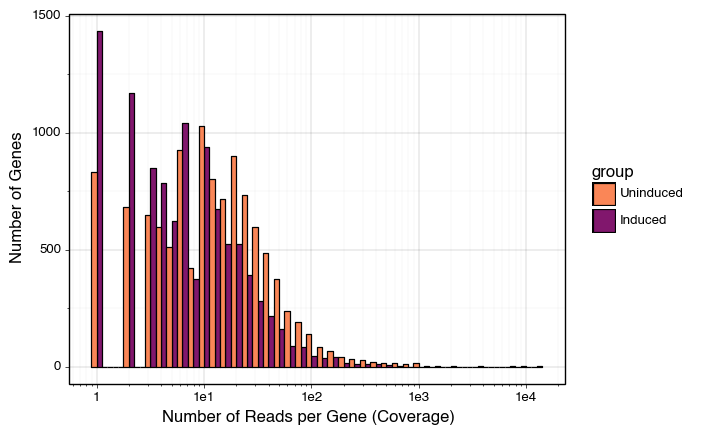

<ggplot: (8762956259793)>

In [16]:
# Plot coverage data separated by treatment group
my_colours = ['#FA8657', '#81176D']

plt_cov = (ggplot
     (data=df_cov, mapping=aes( x='nReadsPerGene', fill = 'group')) + 
      geom_histogram(binwidth = .1, position = 'dodge', colour = 'black') +
      theme_linedraw(base_size = 12, base_family = 'Helvetica') +
      xlab('Number of Reads per Gene (Coverage)') +
      ylab('Number of Genes') +
      scale_fill_manual(values = my_colours) +
#       coord_cartesian(ylim = (.1,4)) +
      scale_x_log10()
#       scale_y_log10()
#       annotation_logticks(sides = "b") +
#       xlim(0,4)
     
    )

plt_cov

In [17]:
# Make a dataframe of read lengths for each sample
df_len_list = []
for file in dataFiles:
    df_len_list.append(get_read_lengths(file))

data_len = pd.concat(df_len_list)

In [18]:
# Add a new column to separate data by untreated or DMSO (combine replicates)
data_len['sample'] = data_len['sample'].astype('string')
data_len['group'] = pd.np.where(data_len['sample'].str.contains("untreated"), "Uninduced", "Induced") # group by uninduced or DMSO string in sample name

cat_type = CategoricalDtype(categories=['Uninduced', 'Induced'], ordered=True) # turn group column into a category variable in order to control order of plotting

data_len['group'] = data_len['group'].astype(cat_type) 

### Figure 1B

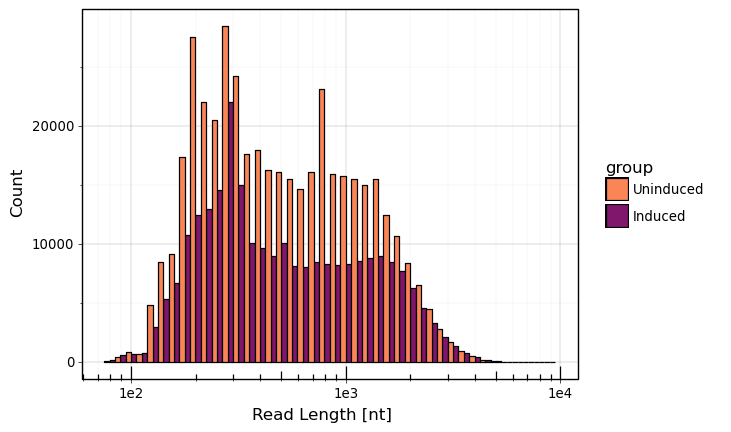

<ggplot: (8762954733901)>

In [19]:
plt_len = (ggplot
     (data=data_len, mapping=aes( x='length', fill = 'group')) + 
      geom_histogram(binwidth = .05, position = 'dodge', colour = 'black') +
      theme_linedraw(base_size = 12) +
      xlab('Read Length [nt]') +
      ylab('Count') +
      scale_x_log10() + 
      scale_fill_manual(values = my_colours) +
      annotation_logticks(sides = "b")
    )

plt_len

In [20]:
# Group read lengths by sample and summarize data in table
tbl_len = data_len.groupby('sample')['length'].describe()
tbl_len

,count,mean,std,min,25%,50%,75%,max
sample,,,,,,,,
1_untreated_RSII,14994.0,678.509937,570.622443,80.0,252.0,451.0,951.0,5016.0
1_untreated_SQ,163876.0,508.428074,471.221315,80.0,221.0,316.0,624.0,6647.0
2_untreated_RSII,32497.0,778.184294,570.972645,80.0,299.0,664.0,1068.0,5185.0
2_untreated_SQ,217732.0,853.865229,693.767979,80.0,302.0,641.0,1220.0,6971.0
3_DMSO_RSII,9076.0,617.802777,537.932208,83.0,261.0,377.0,841.0,5100.0
3_DMSO_SQ,114676.0,533.258302,469.420577,80.0,250.0,339.0,647.0,8580.0
4_DMSO_RSII,13036.0,700.521326,638.588163,80.0,237.0,432.0,987.0,4801.0
4_DMSO_SQ,118394.0,939.241423,802.306360,80.0,278.0,681.5,1438.0,8646.0


In [21]:
# Group read lengths by treatment and summarize data in table
tbl_len_trt = data_len.groupby('group')['length'].describe()
tbl_len_trt

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
Uninduced,429099.0,710.081301,625.700055,80.0,259.0,466.0,969.0,6971.0
Induced,255182.0,733.169471,683.361898,80.0,257.0,438.0,1031.0,8646.0


In [23]:
# Save outputs to file

plt_len.save(filename = 'library_lengths.pdf') # Fig 1B
plt_cov.save(filename = 'library_cov.pdf') # Fig 1C

tbl_len.to_csv('read_lengths_summary_stats.csv', 
               sep = '\t', 
               index = True, 
               header = True)
tbl_cov.to_csv('coverage_summary_stats.csv', 
               sep = '\t', 
               index = True, 
               header = True)